In [1]:
import os
import random
from PIL import Image
from tqdm import tqdm

BASE_DIR = '/kaggle/input/10-class-for-car-logo'
OUTPUT_DIR = '/kaggle/working/dataset'

logo_dir = os.path.join(BASE_DIR, 'TestingData/TestingData/Toyota')
background_dir = os.path.join(BASE_DIR, 'TrainingData/TrainingData/VW')

splits = ['train', 'val', 'test']
classes = ['positive', 'negative']

for split in splits:
    for cls in classes:
        os.makedirs(os.path.join(OUTPUT_DIR, split, cls), exist_ok=True)
        
def augment_logo(logo):
    angle = random.uniform(-30, 30)
    logo = logo.rotate(angle, expand=True)
    scale = random.uniform(0.5, 1.5)
    w, h = logo.size
    logo = logo.resize((int(w * scale), int(h * scale)))
    alpha = random.uniform(0.5, 1.0)
    logo.putalpha(int(255 * alpha))
    return logo

logo_files = [os.path.join(logo_dir, f) for f in os.listdir(logo_dir)
              if f.endswith(('.png', '.jpg', '.jpeg'))]
background_files = [os.path.join(background_dir, f) for f in os.listdir(background_dir)
                    if f.endswith(('.png', '.jpg', '.jpeg'))]

total_positive = 800
total_negative = 800
split_ratios = {'train': 0.7, 'val': 0.15, 'test': 0.15}

def get_split_name(idx, total):
    val_thresh = int(total * split_ratios['train'])
    test_thresh = int(total * (split_ratios['train'] + split_ratios['val']))
    if idx < val_thresh:
        return 'train'
    elif idx < test_thresh:
        return 'val'
    else:
        return 'test'

i = 0
pbar = tqdm(total=total_positive, desc='Generating positive samples')
while i < total_positive:
    bg_path = random.choice(background_files)
    logo_path = random.choice(logo_files)
    try:
        bg = Image.open(bg_path).convert('RGB')
        logo = Image.open(logo_path).convert('RGBA')
    except Exception as e:
        print(f"Error opening image: {e}")
        continue

    logo = augment_logo(logo)
    if logo.width > bg.width or logo.height > bg.height:
        logo.thumbnail((bg.width, bg.height))

    max_x = bg.width - logo.width
    max_y = bg.height - logo.height
    if max_x < 0 or max_y < 0:
        continue

    x = random.randint(0, max_x)
    y = random.randint(0, max_y)
    bg.paste(logo, (x, y), logo)

    split = get_split_name(i, total_positive)
    bg.save(os.path.join(OUTPUT_DIR, split, 'positive', f'pos_{i}.jpg'))
    i += 1
    pbar.update(1)
pbar.close()

i = 0
pbar = tqdm(total=total_negative, desc='Generating negative samples')
while i < total_negative:
    bg_path = random.choice(background_files)
    try:
        bg = Image.open(bg_path).convert('RGB')
    except Exception as e:
        print(f"Error opening background image: {e}")
        continue

    split = get_split_name(i, total_negative)
    bg.save(os.path.join(OUTPUT_DIR, split, 'negative', f'neg_{i}.jpg'))
    i += 1
    pbar.update(1)
pbar.close()

Generating negative samples: 100%|██████████| 800/800 [00:01<00:00, 570.90it/s]


In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

dataset_dir = OUTPUT_DIR
img_size = (150, 150)
batch_size = 32

datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = datagen.flow_from_directory(
    directory=os.path.join(dataset_dir, 'train'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = datagen.flow_from_directory(
    directory=os.path.join(dataset_dir, 'val'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = datagen.flow_from_directory(
    directory=os.path.join(dataset_dir, 'test'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

2025-11-25 19:36:54.003615: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764099414.234117      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764099414.298370      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Found 1120 images belonging to 2 classes.
Found 240 images belonging to 2 classes.
Found 240 images belonging to 2 classes.


In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def build_xception(input_shape=(150, 150, 3), num_classes=1):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(16, (3, 3), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    skip = layers.Conv2D(32, (1, 1), strides=(2, 2), padding='same')(x)
    skip = layers.BatchNormalization()(skip)

    x = layers.SeparableConv2D(32, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x)
    x = layers.add([x, skip])

    skip = layers.Conv2D(64, (1, 1), strides=(2, 2), padding='same')(x)
    skip = layers.BatchNormalization()(skip)

    x = layers.SeparableConv2D(64, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x)
    x = layers.add([x, skip])

    x = layers.SeparableConv2D(128, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(32, activation='relu')(x)
    outputs = layers.Dense(num_classes)(x)

    model = models.Model(inputs, outputs)
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    return model

model = build_xception()
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    callbacks=[early_stop]
)

I0000 00:00:1764099429.276637      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1764099429.277232      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1764099435.125087     133 service.cc:148] XLA service 0x7b8ed009fd30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764099435.126140     133 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1764099435.126171     133 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1764099435.857294     133 cuda_dnn.cc:529] Loaded cuDNN version 90300


 3/35 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.4566 - loss: 0.7493 

I0000 00:00:1764099443.047148     133 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


35/35 ━━━━━━━━━━━━━━━━━━━━ 16s 101ms/step - accuracy: 0.5883 - loss: 0.6355 - val_accuracy: 0.5000 - val_loss: 0.6835
Epoch 2/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.8469 - loss: 0.3958 - val_accuracy: 0.5000 - val_loss: 0.6659
Epoch 3/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.8604 - loss: 0.3248 - val_accuracy: 0.5000 - val_loss: 0.6535
Epoch 4/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.8839 - loss: 0.2797 - val_accuracy: 0.5750 - val_loss: 0.6426
Epoch 5/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.8967 - loss: 0.2359 - val_accuracy: 0.7417 - val_loss: 0.6331
Epoch 6/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9335 - loss: 0.1743 - val_accuracy: 0.6708 - val_loss: 0.5904
Epoch 7/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9535 - loss: 0.1400 - val_accuracy: 0.5542 - val_loss: 0.5762
Epoch 8/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9588 - loss: 0.1197 - val_accuracy: 0.5208 - val_loss: 


Evaluating on test data...
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step
Test accuracy: 0.9625
 Min: 0.0000, Max: 1.0000
 Mean: 0.5254, Std: 0.4650


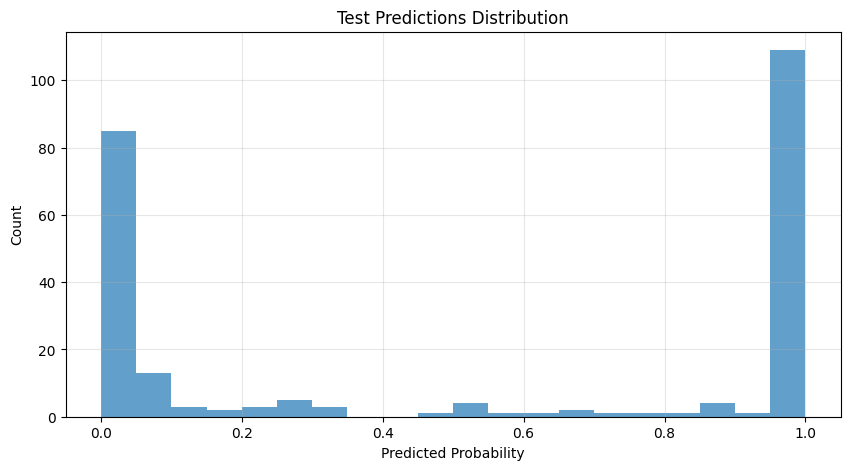

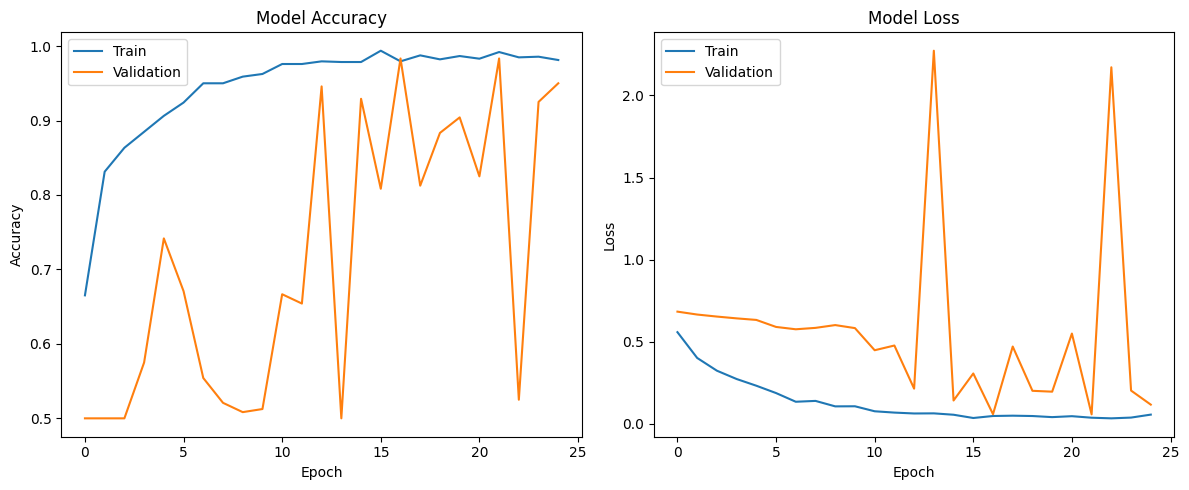

In [4]:
import numpy as np
import matplotlib.pyplot as plt
print("\nEvaluating on test data...")
test_logits = model.predict(test_generator)
test_probs = tf.nn.sigmoid(test_logits).numpy().flatten()
test_preds = (test_probs > 0.5).astype(int)
test_labels = test_generator.labels
test_acc = np.mean(test_preds == test_labels)

print(f"Test accuracy: {test_acc:.4f}")
print(f" Min: {test_probs.min():.4f}, Max: {test_probs.max():.4f}")
print(f" Mean: {test_probs.mean():.4f}, Std: {test_probs.std():.4f}")

plt.figure(figsize=(10, 5))
plt.hist(test_probs, bins=20, alpha=0.7)
plt.title('Test Predictions Distribution')
plt.xlabel('Predicted Probability')
plt.ylabel('Count')
plt.grid(alpha=0.3)
plt.savefig('test_predictions.png')

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'],
label='Validation') 
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'],
label='Validation') 
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.savefig('training_history.png')

In [5]:
model_save_path = '/kaggle/working/xception_model.keras'
model.save(model_save_path)
print(f"✅ Модель збережена: {model_save_path}")

✅ Модель збережена: /kaggle/working/xception_model.keras


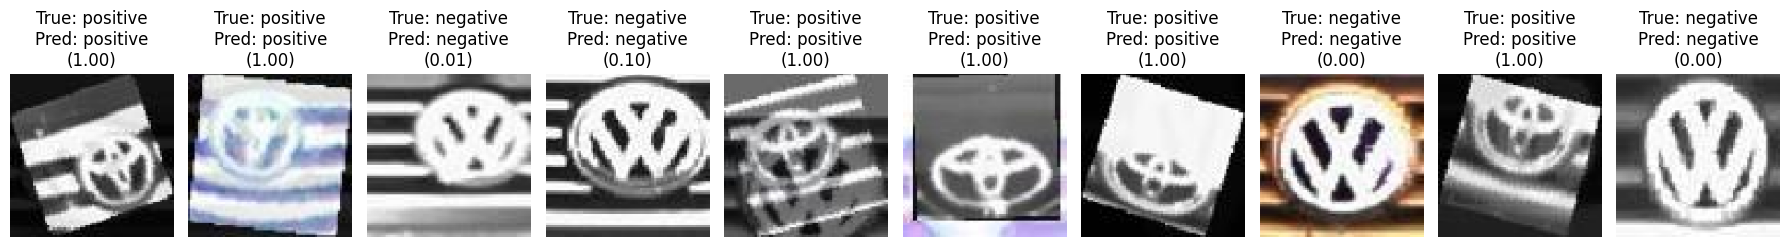

In [6]:
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

num_samples = 10

class_names = list(test_generator.class_indices.keys())

num_test_samples = len(test_generator.labels)

random_indices = random.sample(range(num_test_samples), num_samples)

plt.figure(figsize=(18, 8))

for i, index in enumerate(random_indices):
    image_path = test_generator.filepaths[index]
    true_label = test_generator.labels[index]

    img = tf.keras.utils.load_img(image_path, target_size=model.input_shape[1:3])
    img_array = tf.keras.utils.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    predictions = model.predict(img_array, verbose=0)
    probabilities = tf.nn.sigmoid(predictions).numpy().flatten()

    predicted_class = 1 if probabilities[0] > 0.5 else 0
    predicted_label = class_names[predicted_class]
    true_label_name = class_names[true_label]

    plt.subplot(1, num_samples, i + 1)
    plt.imshow(img)
    plt.title(f"True: {true_label_name}\nPred: {predicted_label}\n({probabilities[0]:.2f})")
    plt.axis('off')

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━

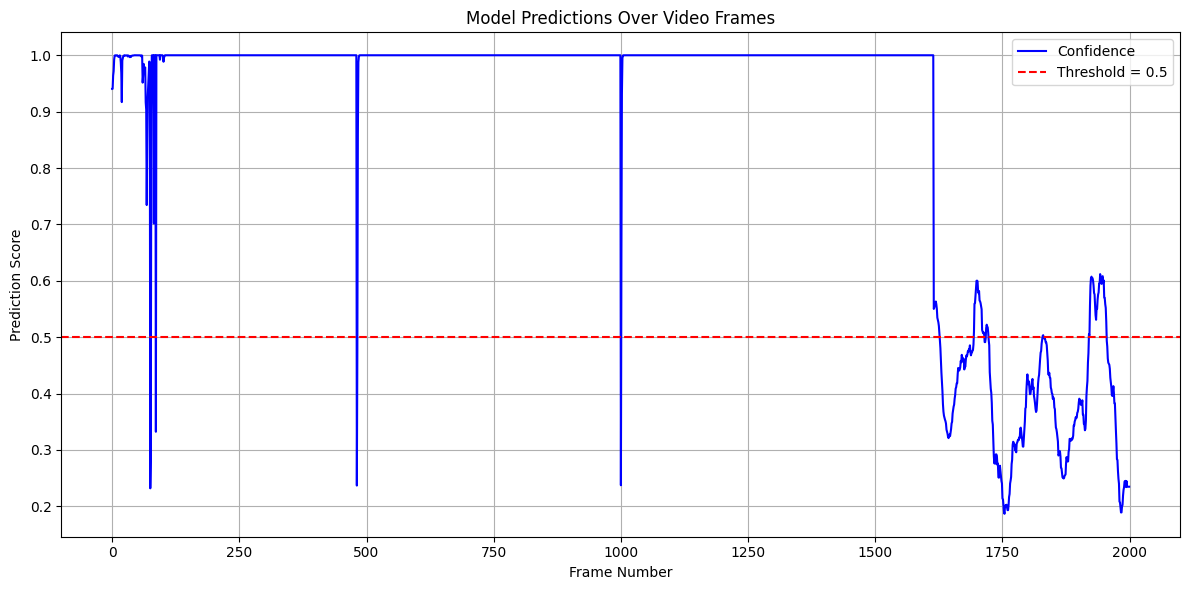

In [7]:
import cv2
from tensorflow.keras.applications.inception_v3 import preprocess_input

video_path = '/kaggle/input/videolab6/toyota-logo-animation-green-screen-footage-free_2D8cYY1b.mp4'
cap = cv2.VideoCapture(video_path)
batch_size = 32

frames, frame_ids, frame_predictions, frame_numbers = [], [], [], []
frame_count = 0

def process_batch(batch_frames, batch_ids):
    batch_np = np.array(batch_frames).astype(np.float32)
    batch_np = preprocess_input(batch_np)
    predictions = model.predict(batch_np)
    for i in range(len(predictions)):
        score = 1 / (1 + np.exp(-predictions[i][0]))
        frame_predictions.append(score)
        frame_numbers.append(batch_ids[i])

while True:
    ret, frame = cap.read()
    if not ret:
        break

    resized_frame = cv2.resize(frame, (150, 150))
    frames.append(resized_frame)
    frame_ids.append(frame_count)

    if len(frames) == batch_size:
        process_batch(frames, frame_ids)
        frames, frame_ids = [], []
    frame_count += 1

if frames:
    process_batch(frames, frame_ids)

cap.release()

plt.figure(figsize=(12, 6))
plt.plot(frame_numbers, frame_predictions, label='Confidence', color='blue')
plt.axhline(0.5, color='red', linestyle='--', label='Threshold = 0.5')
plt.xlabel('Frame Number')
plt.ylabel('Prediction Score')
plt.title('Model Predictions Over Video Frames')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()